In [1]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points, plotting_positions, Weibull_probability_plot
from reliability.Utils import axes_transforms, probability_plot_xylims, probability_plot_xyticks, linear_regression
from reliability.Distributions import Weibull_Distribution

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler
from matplotlib import colors, colormaps
import matplotlib.ticker as mticker
import pandas as pd
from matplotlib.figure import figaspect
import seaborn as sns
import numpy as np
from scipy.special import gamma
from scipy.stats import weibull_min, linregress
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import interpolate
import itertools
import math
from shapely import Polygon
from shapely.plotting import plot_polygon

# Configuration

In [2]:
angle_method = True ## Calculate strength via fracture angle or simple diameter
design_prob = 1-0.05 ## Desired quantile of survival for design

In [3]:
stress_label = "Failure stress (MPa)"
v_label = "Volume ($mm^3$)"
sa_label = "Surface area ($mm^2$)"

In [4]:
plt.style.use('seaborn-v0_8-ticks')
mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["scatter.marker"] = "."

In [5]:
marker_cycler = itertools.cycle(("o", "^", "x", "+"))

# Load in and clean data

In [6]:
fibre_data = pd.read_csv("Maple Rod Testing Analysis.csv")

In [7]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(fibre_data):
    # Drop rows with missing data in column: 'fracture_stress'
    fibre_data = fibre_data.dropna(subset=['fracture_stress'])
    fibre_data = fibre_data.dropna(how="all", axis=1)
    return fibre_data

fibre_data_clean = clean_data(fibre_data.copy())

In [8]:
fibre_data_clean["series"] = fibre_data_clean["sample"].str[0] ## Extract series letter from the "sample" column

In [ ]:
fibre_data_clean

NameError: name 'gcc_data_clean' is not defined

# Analyse Strength

## Functions

In [ ]:
def simple_fracture_stress(load, support_span, load_span, diameter):
    ### Calculate fracture stress without accounting for fracture angle
    pin_distance = (support_span - load_span) / 2
    return (16 * load * pin_distance) / (np.pi * diameter**3)

In [ ]:
def calc_fracture_stress(sample_data):
    ### Batch calculate simple fracture stress
    sample_data["old_fracture_stress"] = sample_data["fracture_stress"]
    sample_data["fracture_stress"] = sample_data.apply(lambda row: simple_fracture_stress(row["fracture_load"], row["support_span"], row["load_span"], row["fracture_diameter"]), axis=1)
    return sample_data

In [ ]:
def fit_and_plot_weibull(data, design_failure):
    ### Big function to fit and plot the needed weibull distributions of each series. Saves a figure of individual and collated distributions

    ## Set up matplotlib figures and axes
    ind_fig, ind_ax = plt.subplots()
    collated_fig, collated_ax = plt.subplots()
    
    ## Create a separate dataframe with statistics considering the entire series
    data_anal = data[["series", "fracture_diameter", "fracture_stress"]].groupby("series").agg(['mean', "std"])
    data_anal.columns = data_anal.columns.map('_'.join)
    data_anal["fracture_stress_CV"] = data_anal["fracture_stress_std"] / data_anal["fracture_stress_mean"] * 100

    ## Sort the values to display nicer in figure legends
    data_anal = data_anal.sort_values("fracture_diameter_mean")

    fracture_prob = pd.DataFrame()

    unique_values = data_anal.index.unique()

    ## Fit a weibull distribution to each series, also keeping the plotting positions to be scaled later
    for letter in unique_values:
        fracture_frame = data.loc[data["series"] == letter, ["fracture_stress"]].copy()
        plot_data = fracture_frame.squeeze(axis=1).to_numpy(dtype="float32")

        data_anal.loc[letter, "support_span"] = data.loc[data["series"] == letter, "support_span"].iloc[0]
        data_anal.loc[letter, "load_span"] = data.loc[data["series"] == letter, "load_span"].iloc[0]

        ## Skip fitting if sample size is too small
        if len(plot_data) < 2: continue
        
        avg_diameter = data_anal.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm dia." % (letter, avg_diameter)
        
        plt.sca(ind_ax)
        ## Fit the current data to a weibull (Also makes a figure)
        fracture_fit = Fit_Weibull_2P(failures=plot_data, print_results=False, label=legend_text, method="LS", CI_type="none")
        
        ## Individual figure formatting
        ind_ax.get_lines()[0].set_color("red")
        ind_ax.get_lines()[0].set_linestyle("dashed")
        ind_fig.set_size_inches(7, 8)
        plt.ylabel("Probability of failure")
        plt.xlabel(stress_label)
        plt.title("")
        plt.legend(loc="upper left")

        ## Save and clear fig
        ind_fig.savefig("Figs/series_" + letter, bbox_inches = "tight")
        ind_ax.cla()

        ## Also grab the plotting positions from the reliability library
        fail_x, fail_y = plotting_positions(plot_data)
        fracture_frame.loc[:, "Fail Check"] = fail_x ## This should be the same as "fracture_stress"
        fracture_frame.loc[:, "Fail Prob"] = fail_y

        fracture_frame["char_strength"] = fracture_fit.alpha
        fracture_frame["weibull_modulus"] = fracture_fit.beta

        fracture_frame = fracture_frame.drop(["fracture_stress"], axis=1)
        fracture_prob =  pd.concat([fracture_prob, fracture_frame], axis=0)

        data_anal.loc[letter, "valid_samples"] = len(plot_data)
        data_anal.loc[letter, "char_strength"] = fracture_fit.alpha
        data_anal.loc[letter, "char_strength_95%_upper"] = fracture_fit.alpha_upper
        data_anal.loc[letter, "char_strength_95%_lower"] = fracture_fit.alpha_lower
        data_anal.loc[letter, "weibull_modulus"] = fracture_fit.beta
        data_anal.loc[letter, "weibull_modulus_95%_upper"] = fracture_fit.beta_upper
        data_anal.loc[letter, "weibull_modulus_95%_lower"] = fracture_fit.beta_lower
        data_anal.loc[letter, "Design Strength"] = fracture_fit.distribution.inverse_SF(design_failure)

        collated_legend_text = "%s, dia.= ~%.2f mm" % (letter, avg_diameter)

        ## Add a line to the collated figure
        plt.sca(collated_ax)
        Weibull_probability_plot(failures=plot_data, __fitted_dist_params=fracture_fit.distribution, show_scatter_points=False, CI_type=None, label=collated_legend_text)

    ind_fig.clf()

    ## Collated figure formatting and save
    collated_ax.set_title("")
    collated_ax.set_ylabel("Probability of failure")
    collated_ax.set_xlabel(stress_label)

    collated_fig.set_size_inches(7, 8)

    collated_ax.set_xlim([10, 300])
    collated_ax.set_ylim([0.1, 0.9])

    collated_fig.savefig("Figs/collated", bbox_inches = "tight")

    ## Save relevant data back to the original dataframe
    data = pd.concat([data, fracture_prob], axis=1)

    return data, data_anal

## Run Analysis

In [ ]:
## GCC uses fracture angle to alter the maximum stress experienced. Set angle_method = FALSE if you want to use "normal" maximum stress

if not angle_method:
    gcc_data_clean = calc_fracture_stress(gcc_data_clean)
    gcc_data_clean

<Figure size 700x800 with 0 Axes>

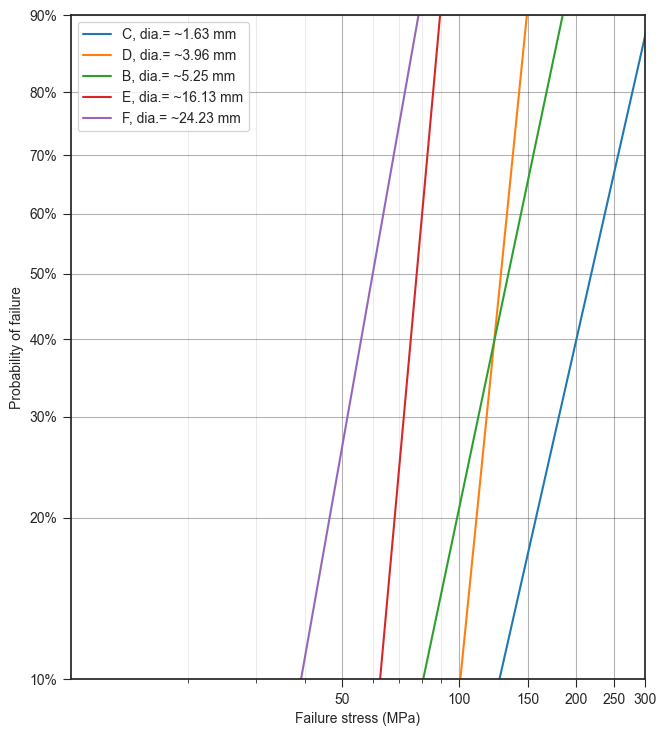

In [ ]:
gcc_data_clean, gcc_data_anal = fit_and_plot_weibull(gcc_data_clean, design_prob)

In [ ]:
## Double check if appended plotting positions align with original fracture stress

check_alignment = gcc_data_clean[["fracture_stress", "Fail Check"]].dropna()

check_alignment = np.isclose(check_alignment["fracture_stress"], check_alignment["Fail Check"])
check_alignment

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])